<a href="https://colab.research.google.com/github/Lee-jun-young98/Penguin-s_weight_prediction_dacon/blob/main/%ED%8E%AD%EA%B7%84%EB%AA%B8%EB%AC%B4%EA%B2%8C%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

import os 
os.chdir("/content/gdrive/MyDrive/Dacon/penguin's_weight_prediction/")
os.getcwd()

Mounted at /content/gdrive/


"/content/gdrive/MyDrive/Dacon/penguin's_weight_prediction"

In [ ]:
!pip install catboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgbm
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

     |████████████████████████████████| 76.3 MB 60 kB/s 


In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
# id 컬럼 삭제 (114,11)
train = train.drop("id", axis=1)
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              114 non-null    object 
 1   Island               114 non-null    object 
 2   Clutch Completion    114 non-null    object 
 3   Culmen Length (mm)   114 non-null    float64
 4   Culmen Depth (mm)    114 non-null    float64
 5   Flipper Length (mm)  114 non-null    int64  
 6   Sex                  111 non-null    object 
 7   Delta 15 N (o/oo)    111 non-null    float64
 8   Delta 13 C (o/oo)    111 non-null    float64
 9   Body Mass (g)        114 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 9.0+ KB


In [ ]:
train.isnull().sum() # sex 변수, Delta 15N (o/oo), Delta 13C (o/oo) 변수 결측치 3개

Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    3
Delta 15 N (o/oo)      3
Delta 13 C (o/oo)      3
Body Mass (g)          0
dtype: int64

In [ ]:
train_num_col = train.loc[:,['Culmen Length (mm)','Culmen Depth (mm)', 'Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Body Mass (g)']]

In [ ]:
train_obj_col = train.loc[:,['Species', 'Island', 'Clutch Completion', 'Sex']]

# 수치형 변수 상관관계 시각화
Culmen Legnth (mm)과 Flipper Length(mm)은 양의 상관관계를 보임 0.67

Culmen Depth (mm)과 Flipper Length(mm)과 음의 상관관계를 보임 -0.6

Culmen Depth (mm)과 Delta 15N(o/oo)과 양의 상관관계를 보임 0.65

Flipper Length (mm)과 Delta 15N(o/oo)과 음의 상관관계를 보임 - 0.53

Culmen Length(mm)과 Flipper Length(mm)은 Body Mass(g)와 양의 상관관계를 보임 0.57, 0.86

Culmen Depth(mm), Delta 15 N(o/oo), Delta 13 C(o/oo)와 음의 상관관계를 보임 -0.49, -0.55, -0.47

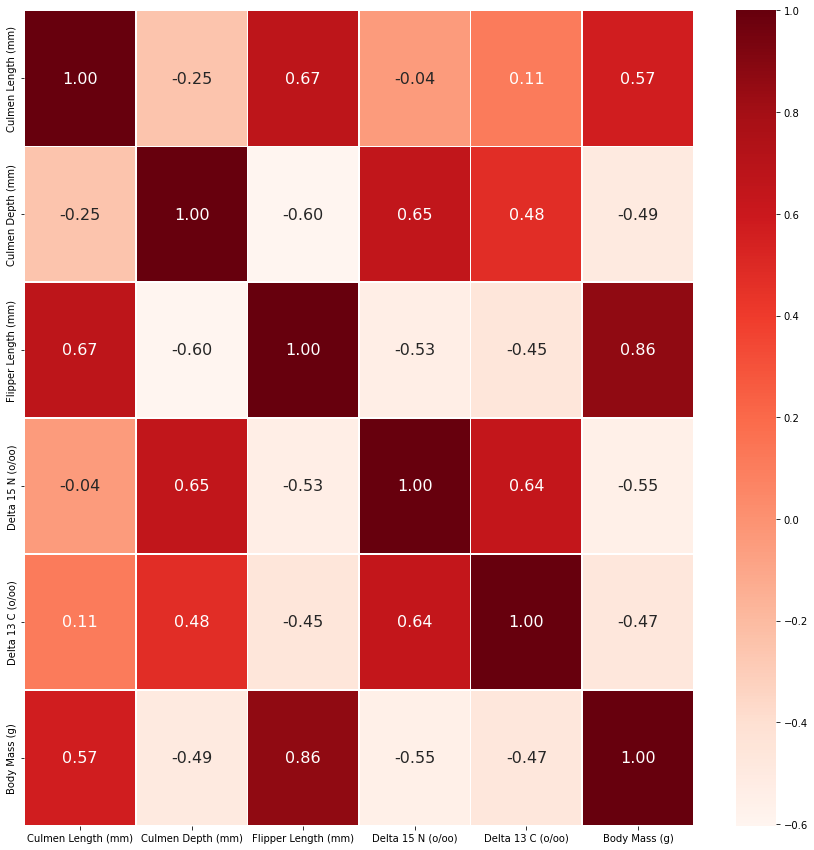

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(data = train_num_col.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap="Reds",annot_kws={"size": 16})

In [ ]:
train.isnull() # sex : 6번행 8번행 71번행 delta 15 8, 18, 109 delta 13 8, 18, 109 

,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
109,False,False,False,False,False,False,False,True,True,False
110,False,False,False,False,False,False,False,False,False,False
111,False,False,False,False,False,False,False,False,False,False
112,False,False,False,False,False,False,False,False,False,False


In [ ]:
train['Species'].value_counts()

Gentoo penguin (Pygoscelis papua)            48
Adelie Penguin (Pygoscelis adeliae)          41
Chinstrap penguin (Pygoscelis antarctica)    25
Name: Species, dtype: int64

In [ ]:
train['Island'].value_counts()

Biscoe       57
Dream        44
Torgersen    13
Name: Island, dtype: int64

In [ ]:
train['Sex'].value_counts()

MALE      56
FEMALE    55
Name: Sex, dtype: int64

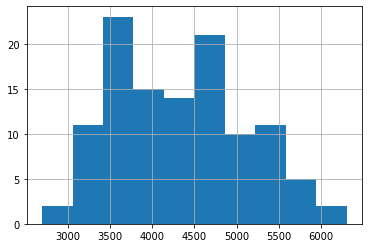

In [ ]:
train['Body Mass (g)'].hist()

In [ ]:
train.fillna(train.mean(), inplace = True)
test.fillna(train.mean(), inplace = True)
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print(train.shape)
print(test.shape)

(114, 16)
(228, 16)


In [ ]:
discrete_names = ['Species', 'Island', 'Clutch Completion', 'Sex']
continuous_names = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_scaler = scaler.fit_transform(train[continuous_names])
train[continuous_names] = pd.DataFrame(data=train_scaler, columns=continuous_names)

test_scaler = scaler.transform(test[continuous_names])
test[continuous_names] = pd.DataFrame(data=test_scaler, columns=continuous_names)

train[continuous_names].head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo)
0,1.016685,-0.887255,1.161653,-0.775548,0.630951
1,0.922318,1.027037,-0.209242,1.601553,1.629486
2,0.091884,-1.352893,0.476205,-0.391149,-1.533908
3,-0.021357,-1.197680,0.750384,-0.962206,-0.523568
4,0.941191,-0.525091,1.504376,-0.635514,-1.325731


In [ ]:
train

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua),Island_Biscoe,Island_Dream,Island_Torgersen,Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,1.016685,-0.887255,1.161653,-7.755480e-01,6.309514e-01,5550,0,0,1,1,0,0,0,1,0,1
1,0.922318,1.027037,-0.209242,1.601553e+00,1.629486e+00,3800,0,1,0,0,1,0,1,0,0,1
2,0.091884,-1.352893,0.476205,-3.911490e-01,-1.533908e+00,4400,0,0,1,1,0,0,0,1,1,0
3,-0.021357,-1.197680,0.750384,-9.622064e-01,-5.235685e-01,4850,0,0,1,1,0,0,0,1,1,0
4,0.941191,-0.525091,1.504376,-6.355139e-01,-1.325731e+00,5700,0,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,-1.512363,0.406186,-1.237413,-6.370870e-15,1.261964e-14,3700,1,0,0,0,0,1,0,1,1,0
110,-1.021652,0.820087,-0.894689,6.678491e-01,-8.577043e-02,4250,1,0,0,0,1,0,0,1,0,1
111,-0.266712,0.768349,-0.757600,4.171361e-01,-3.714788e-01,4100,1,0,0,0,1,0,0,1,0,1
112,0.431607,-0.214666,-0.757600,1.915640e+00,1.167108e+00,2700,0,1,0,0,1,0,1,0,1,0


In [ ]:
x = train.drop("Body Mass (g)", axis = 1)
y = train["Body Mass (g)"]
test= test.drop("id", axis =1)

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(x,y, random_state = 0)

In [ ]:
xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

print(len(x_train), len(x_val))
xgb_model.fit(x_train,y_train)


85 29
[04:59:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.08, max_depth=7, subsample=0.75)

In [ ]:
models = []
models.append(['Random Forest', RandomForestRegressor(random_state=0)])
models.append(['XGBoost', xgboost.XGBRegressor(eval_metric = 'error')])
models.append(['lightgbm', lgbm.LGBMRegressor(objective="regression")])
models.append(['Catboost', CatBoostRegressor(iterations=200, learning_rate=0.1, eval_metric='RMSE')])
list_1 = []


for m in range(len(models)):
    list_2 = []
    model = models[m][1]
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    print(models[m][0])
    mse = mean_squared_error(y_val, y_pred, squared = False)
    print("============================")
    list_2.append(models[m][0])
    list_2.append(mse)
    list_1.append(list_2)

df = pd.DataFrame(list_1, columns =  ['Model', 'rmse'])

df    

Random Forest
[04:59:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost
lightgbm
0:	learn: 759.2812942	total: 47.1ms	remaining: 9.37s
1:	learn: 715.3295025	total: 48ms	remaining: 4.76s
2:	learn: 674.1039355	total: 48.7ms	remaining: 3.2s
3:	learn: 636.5177347	total: 49.6ms	remaining: 2.43s
4:	learn: 597.9398490	total: 50.4ms	remaining: 1.97s
5:	learn: 565.4120840	total: 51.2ms	remaining: 1.66s
6:	learn: 536.2838565	total: 52.2ms	remaining: 1.44s
7:	learn: 509.4365114	total: 53ms	remaining: 1.27s
8:	learn: 483.7969343	total: 53.8ms	remaining: 1.14s
9:	learn: 464.5024403	total: 54.7ms	remaining: 1.04s
10:	learn: 442.7994250	total: 55.1ms	remaining: 948ms
11:	learn: 421.4445499	total: 56ms	remaining: 877ms
12:	learn: 403.7067712	total: 56.8ms	remaining: 817ms
13:	learn: 389.5689601	total: 57ms	remaining: 757ms
14:	learn: 377.6748750	total: 57.8ms	remaining: 713ms
15:	learn: 364.7398569	total: 58.7ms	remaining: 675

,Model,rmse
0,Random Forest,335.991119
1,XGBoost,407.707758
2,lightgbm,306.630947
3,Catboost,367.682996


In [ ]:
model = lgbm.LGBMRegressor(objective="regression")

In [ ]:
from hyperopt import fmin, hp, tpe, space_eval
from functools import partial

In [ ]:
hyper_space = {'n_estimators': hp.choice('n_estimators',np.arange(50, 150, 10, dtype=int)),
               'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
               'colsample_bytree': hp.uniform('colsample_bytree', 0, 1.0),
               'feature_fraction': hp.uniform('feature_fraction',0, 1.0),
               "bagging_fraction": hp.uniform('bagging_fraction', 0, 1.0),
               'max_depth': hp.choice('max_depth',np.arange(-1, 16, 1, dtype=int)),
               'num_leaves': hp.choice('num_leaves',np.arange(16, 1024, 16, dtype=int)),
               'subsample': hp.uniform('subsample', 0, 1.0),
               'min_child_weight': hp.choice('min_child_weight',np.arange(1, 8, 1, dtype=int))
              }

In [ ]:
def train_score(model, x_train, y_train, x_val, y_val):
    lgb_model = model.fit(x_train, y_train)
    pred = lgb_model.predict(x_val)
    rmse = mean_squared_error(y_val,pred, squared = False)
    return rmse

In [ ]:
def evaluate(params, x_train, y_train, x_val, y_val):
  # Initilize instance of estimator
  est = lgbm.LGBMRegressor(objective='regression', n_jobs=-1, **params)
  #score
  score = train_score(est, x_train, y_train, x_val, y_val)
  return score

In [ ]:
hyperopt_objective = lambda params: evaluate(params, x_train, y_train, x_val, y_val)
algo = partial(tpe.suggest, n_startup_jobs=20, gamma=0.25, n_EI_candidates=24)

In [ ]:
best_vals = fmin(hyperopt_objective, space=hyper_space, algo=algo, max_evals=5500)

100%|██████████| 5500/5500 [11:00<00:00,  8.33it/s, best loss: 266.3401642292718]


In [ ]:
best_params = space_eval(hyper_space, best_vals)
best_params

{'bagging_fraction': 0.991322819581879,
 'colsample_bytree': 0.7815332839288827,
 'feature_fraction': 0.677142921194248,
 'learning_rate': 0.059828104830696845,
 'max_depth': 1,
 'min_child_weight': 3,
 'n_estimators': 100,
 'num_leaves': 544,
 'subsample': 0.6760558093642365}

In [ ]:
n_splits = 5
sfk = StratifiedKFold(n_splits = n_splits)

y_pred = np.zeros(len(test))
# train데이터셋에서 건물의 비율을 동일하게하기 위해 StratifiedKFold 사용
for n, (train_idx, validation_idx) in enumerate(sfk.split(x, y)):      
    x_train, x_validation = train.iloc[train_idx], train.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]
    model = lgbm.LGBMRegressor(**best_params, random_state=0)
    model.fit(x_train, y_train, eval_set=[(x_validation, y_validation)], early_stopping_rounds= 30, verbose=100)
    y_pred = model.predict(x_validation)
    mse = mean_squared_error(y_validation, y_pred, squared = False)
    print("{}번째 rmse는 {}".format(n, mse))
   


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[54]	valid_0's l2: 21548.8
0번째 rmse는 146.79494949822043
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's l2: 72412.3
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 72412.3
1번째 rmse는 269.09536687120726
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's l2: 99560.7
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 99560.7
2번째 rmse는 315.5324620493113
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's l2: 41335.9
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 41335.9
3번째 rmse는 203.31230972273994
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's l2: 20375
Did not meet early stopping. Best iteration is:
[74]	valid_0's l2: 19805.2
4번째 rmse는 140.73103431451466


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [ ]:
lgb_model = model.fit(x, y)
predictions = model.predict(test)

In [ ]:
submission = pd.read_csv("sample_submission.csv")

In [ ]:
submission

,id,Body Mass (g)
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
223,223,0
224,224,0
225,225,0
226,226,0


In [ ]:
predd = predictions // 10 * 5

submission["Body Mass (g)"] = predictions 

In [ ]:
submission

,id,Body Mass (g)
0,0,4275.202335
1,1,5417.120392
2,2,3558.909279
3,3,3476.750486
4,4,3617.298945
...,...,...
223,223,4088.579169
224,224,4697.636898
225,225,4610.447246
226,226,4088.579169


In [ ]:
submission.to_csv('baseline.csv', index = False)